In [2]:
import gc, argparse, sys, os, errno
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from beakerx import *
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[1])
sns.set_style(styles[2])

In [4]:
cd /home/chenxupeng/projects/training

/home/chenxupeng/projects/training


In [211]:
ls /Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/

exoRBase/  piranha_peaks/            transcripts_exrna/
GSE71008/  piranha_peaks_iterative/


In [212]:
root_path_full = '/home/chenxupeng/projects/training/data/transcripts_exrna/'
root_path_peak = '/home/chenxupeng/projects/training/data/piranha_peaks/'
root_path_iterative = '/home/chenxupeng/projects/training/data/piranha_peaks_iterative/'
root_path_GSE71008 = '/home/chenxupeng/projects/training/data/GSE71008/'  #Normal_CRC
root_path_exoRBase = '/home/chenxupeng/projects/training/data/exoRBase/'  #Normal-HCC/  Normal-PAAD/

In [213]:
ls /home/chenxupeng/projects/training/data/exoRBase

Normal-HCC/  Normal-PAAD/


In [7]:
ls /Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/transcripts_exrna/Normal-HCC/logistic_regression.100.ranking.leave_one_out/

best_model.pkl               feature_importances.txt  metrics.leave_one_out.txt
evaluation.leave_one_out.h5  features.txt


In [214]:
hccpath = 'Normal-HCC/'
stagepath='Normal-stage_A/'
crcpath = 'Normal-CRC/'
paadpath = 'Normal-PAAD/'

In [215]:
root_path = [root_path_full,root_path_peak,root_path_iterative,root_path_GSE71008,root_path_exoRBase]
sample_path = [hccpath,stagepath,crcpath,paadpath]

In [ ]:
metrics = {}
for i in os.listdir(root_path+hccpath):
    #print (i)
    print (root_path+hccpath+i+'/metrics.stratified_shuffle_split.txt')
    try:
        #print (i, ' file found')
        if i.split('.')[-1] == 'shuffle_split':
            
            metrics[i] = np.loadtxt(root_path+hccpath+i+'/metrics.stratified_shuffle_split.txt',dtype='str')[1:,-1].astype('float')
        else:
            metrics[i] = np.loadtxt(root_path+hccpath+i+'/metrics.leave_one_out.txt',dtype='str')[1:,-1].astype('float')
    except:
        print (i, ' file not found')
        print ('files in the directory: ',os.listdir(root_path+hccpath+i))

### plot AUC：
- probability
    - for leave one out, each row is one round, only one sample is test sample, merge all to plot one(43 sample in one curver)
    - for shuffle, each row is one round, several samples are selected as test samples, one row can be plotted as one curve. only plot one curve with CI is enough.
- sample label
    file:
    
- CI
- some statistics: 
    - annotate spe and sen point!
    - for CI, annotate three

In [216]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
def get_probs_split(root_path,samplepath,filename,interpolatednum=50,confidence=0.95):
    '''
    get probs from split
    use interpolation to calculate CI
    '''
    xvals = np.linspace(0, 1, interpolatednum)
    with h5py.File(root_path+samplepath+filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        #print (list(f.keys()))
        label = f['labels'][:]
    probs,labels,interpolatedvalue = {},{},{}
    for i in range(predictions.shape[0]):
        probs[i] = predictions[i][~train_index[i]]
        labels[i] = label[~train_index[i]]
        interpolatedvalue[i] = np.interp(xvals,plot_roc( probs[i],labels[i])[1],plot_roc( probs[i],labels[i])[2] )
    interarray = np.array([interpolatedvalue[i]  for i in range(predictions.shape[0])])
    mean,minimum,maximum = np.ndarray([interpolatednum]),np.ndarray([interpolatednum]),np.ndarray([interpolatednum])
    for i in range(interpolatednum):
        mean[i],minimum[i],maximum[i] = mean_confidence_interval(interarray[:,i],confidence)
    return np.concatenate((np.zeros(1),mean,np.ones(1))),np.concatenate((np.zeros(1),minimum,np.ones(1))),\
np.concatenate((np.zeros(1),maximum,np.ones(1))),interpolatednum+2
def plot_roc(prob,label):
    fpr, tpr, _ = roc_curve(label, prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    return roc_auc,fpr, tpr

In [217]:
def find_metrics_best(label,expressionlevel):
    posinum = np.sum(label)
    neganum = label.shape[0] - np.sum(label)
    a,b,c= roc_curve(label,expressionlevel) #fpr tpr threshold
    fp = a*neganum
    tp = b*posinum
    tn = (1-a)*neganum
    fn = (1-b)*posinum
    #Sensitivity = tp/(tp+fn) 
    #Specificity = tn/(tn+fp) 
    Sensitivity = b
    Specificity = 1 - a
    PPV = tp/(tp+fp) 
    NPV = tn/(tn+fn) 
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    mcc_mean = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
    F1_score = 2*tp/(2*tp+fn+fp)
    auc = sklearn.metrics.auc(a,b)
    acc = (tp+tn)/(tp+tn+fn+fp)
    distoleftup = (a**2+(1-b)**2)**0.5# to the left up
    #print ("AUC:" +str(auc)) 
    thres = int(label.shape[0]/10.) if int(label.shape[0]/10.)>0 else 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres],np.argsort(-mcc_mean)[:thres],np.argsort(-F1_score)[:thres])),return_counts=True)
    print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]
    
    
def find_metrics_best_for_shuffle(fpr,tpr):
    '''
    used for shuffle roc plot
    '''
    a = 1 - fpr 
    b = tpr
    #Sensitivity = tp/(tp+fn) 
    #Specificity = tn/(tn+fp) 
    Sensitivity = b
    Specificity = a
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    auc = sklearn.metrics.auc(a,b)
    #print ("AUC:" +str(auc)) 
    thres = 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres])),return_counts=True)
    #print (Sensitivity[uni[np.where(counts ==np.max(counts))][0]])
    #print (Specificity[uni[np.where(counts ==np.max(counts))][0]])
    #print (F1_score)
    #print (np.argsort(-F1_score))
    #print (uni,counts)
    print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]

In [218]:
def plot_jack(root_path,samplepath,filename,savepath,show_metrics=True,savefigure=False,title=None):
    '''
    samplepath: hccpath
    filename: 'logistic_regression.100.ranking.leave_one_out/evaluation.leave_one_out.h5'
    '''
    with h5py.File(root_path+samplepath+filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        label = f['labels'][:]
    prob = predictions[~train_index]
    

    roc,fpr,tpr= plot_roc(prob,label)
        
    auc,sen,spe = find_metrics_best(label,prob)
    label2 = 'AUC: ' + str('%0.4s'%auc) +' ['+str('%0.4s'%spe)+' '+str('%0.4s'%sen)+']'
    #print (sen,spe)
    fig,ax=plt.subplots(1,figsize=(12,12))
    if show_metrics:
        ax.plot(fpr,tpr,linewidth=2,color='b',label='AUC: '+str(np.round(auc,3)))
        if sen+0.2<=0.95:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('TPR '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen-0.1),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
    else:
        ax.plot(fpr,tpr,linewidth=3,color='r',label='AUC: '+str(roc))
    ax.legend(prop={'size': 15})
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if title is not None:
        ax.set_title(title,fontsize= 25)
    else:
        ax.set_title('Receiver Operating Characteristic Curve',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()

In [219]:
def plot_shuffle(root_path,samplepath,filename,savepath,show_metrics=True,savefigure=False,title=None):
    '''
    samplepath: hccpath
    filename: 'logistic_regression.100.robust.stratified_shuffle_split/evaluation.stratified_shuffle_split.h5'
    '''
    mean,minimum,maximum,interpolatednum = get_probs_split(root_path,samplepath,filename)
    fig,ax=plt.subplots(1,figsize=(12,12))
    xvals = np.linspace(0, 1, interpolatednum)
    #print (interpolatednum)
    fill_between(xvals,minimum,maximum,where=(minimum<=maximum),color='b',alpha=0.1)
    
    auc,sen,spe = find_metrics_best_for_shuffle(xvals,mean) #tpr,1-fpr
    #label2 = 'AUC: ' + str('%0.4s'%auc) +' ['+str('%0.4s'%spe)+' '+str('%0.4s'%sen)+']'
    #print (sen,spe)
    # calculate min and max's corresponding tpr
    #print (1-spe,1./(interpolatednum-2))
    numind = np.ceil((1-spe)/(1./(interpolatednum-2))).astype('int')
    #print (numind)
    ax.plot(xvals,mean,linewidth=1,color='b',label='AUC: '+str(np.round(auc,3)))
    ax.plot(xvals,minimum,linewidth=1,color='b')
    ax.plot(xvals,maximum,linewidth=1,color='b')
    if show_metrics:
        if sen+0.2<=0.95:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('FPR '+str('%0.4s'%(1-spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('TPR '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen),
            arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
            )
        #ax.annotate('TPR '+str('%0.4s'%minimum[numind]), xy=( 1-spe,minimum[numind]), xytext=(1-spe+0.1, minimum[numind]),
            #arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
           # )
        #ax.annotate('TPR '+str('%0.4s'%maximum[numind]), xy=( 1-spe,maximum[numind]), xytext=(1-spe+0.1, maximum[numind]),
           # arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
           # )
    ax.legend(prop={'size': 15})
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    if title is not None:
        ax.set_title(title,fontsize= 25)
    else:
        ax.set_title('Receiver Operating Characteristic Curve',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()

In [220]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[2])
sns.set_style(styles[2])

In [221]:
def get_auc_stats(root_path,sample_path=hccpath):
    '''
    sample_path:hccpath,stagepath
    '''
    auc_metrics_jack = {}
    auc_metrics_split = {}
    for i in os.listdir(root_path+sample_path):
        #print (i)
        try:
            print (i, ' file found')
            if i.split('.')[-1] == 'shuffle_split':
                auc_metrics_split[i] = h5py.File(root_path+sample_path+i+'/evaluation.shuffle_split.h5')
            else:
                with h5py.File(root_path+sample_path+i+'/evaluation.leave_one_out.h5','r') as f:
                    predictions =  f['predictions'][:]
                    train_index =  f['train_index'][:]
                    auc_metrics_jack[i]  = predictions[~train_index]
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))
    return auc_metrics_jack,auc_metrics_split

In [222]:
def plot_auc_stats(root_path,sample_path=hccpath):
    '''
    sample_path:hccpath,stagepath
    '''
    auc_metrics_jack = {}
    auc_metrics_split = {}
    print (root_path+sample_path)
    for i in os.listdir(root_path+sample_path):
        #print (i)
        try:
            print (i, ' file found')
            if i.split('.')[-1] == 'stratified_shuffle_split':
                plot_shuffle(root_path,sample_path,i+'/evaluation.stratified_shuffle_split.h5',
                             savepath='data/rocplot/'+root_path.split('/')[-2]+'/'+sample_path+'/'+i+'.png',show_metrics=True,savefigure=True,title=i+ ' ROC')
                
            else:
                plot_jack(root_path,sample_path,i+'/evaluation.leave_one_out.h5',
                         savepath='data/rocplot/'+root_path.split('/')[-2]+'/'+sample_path+'/'+i+'.png',show_metrics=True,savefigure=True,title=i+ ' ROC')
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))

plot_shuffle(root_path_full,hccpath,'random_forest.30.robust.stratified_shuffle_split/evaluation.stratified_shuffle_split.h5',
                             savepath='data/rocplot/'+root_path_full.split('/')[-2]+'/'+hccpath+'random_forest.30.robust.stratified_shuffle_split'+'.png',
             show_metrics=True,savefigure=True,title='random_forest.30.robust.stratified_shuffle_split ROC')

In [224]:
sample_path

['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/', 'Normal-PAAD/']

In [225]:
root_path

['/home/chenxupeng/projects/training/data/transcripts_exrna/',
 '/home/chenxupeng/projects/training/data/piranha_peaks/',
 '/home/chenxupeng/projects/training/data/piranha_peaks_iterative/',
 '/home/chenxupeng/projects/training/data/GSE71008/',
 '/home/chenxupeng/projects/training/data/exoRBase/']

In [227]:
root_path[4:5]

['/home/chenxupeng/projects/training/data/exoRBase/']

In [231]:
np.array(sample_path)[np.array([0,3])]

array(['Normal-HCC/', 'Normal-PAAD/'], dtype='<U15')

In [232]:
for i in root_path[4:5]:
    for j in np.array(sample_path)[np.array([0,3])]:
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]):
            os.mkdir('data/rocplot/'+i.split('/')[-2])
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/rocplot/'+i.split('/')[-2]+'/'+j)
        print (i)
        plot_auc_stats(root_path=i,sample_path=j)

/home/chenxupeng/projects/training/data/exoRBase/
/home/chenxupeng/projects/training/data/exoRBase/Normal-HCC/
logistic_regression.50.ranking.stratified_shuffle_split  file found
2
logistic_regression.40.robust.stratified_shuffle_split  file found
3
random_forest.40.robust.stratified_shuffle_split  file found
3
logistic_regression.10.rfe.stratified_shuffle_split  file found
3
logistic_regression.30.rfe.leave_one_out  file found
6
logistic_regression.30.rfe.stratified_shuffle_split  file found
3
random_forest.40.robust.leave_one_out  file found
5
logistic_regression.50.rfe.leave_one_out  file found
6
logistic_regression.20.ranking.stratified_shuffle_split  file found
3
random_forest.40.rfe.stratified_shuffle_split  file found
3
logistic_regression.50.ranking.leave_one_out  file found
4
random_forest.30.rfe.leave_one_out  file found
5
random_forest.50.ranking.stratified_shuffle_split  file found
3
random_forest.10.ranking.leave_one_out  file found
5
random_forest.50.rfe.stratified_shuffl

In [ ]:
for i in root_path[3:4]:
    for j in sample_path[2:3]:
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]):
            os.mkdir('data/rocplot/'+i.split('/')[-2])
        if not os.path.exists('data/rocplot/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/rocplot/'+i.split('/')[-2]+'/'+j)
        print (i)
        plot_auc_stats(root_path=i,sample_path=j)

## 绘制clustermap

In [233]:
import pandas as pd
features = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/feature_selection/evaluate/piranha_peaks/Normal-HCC/logistic_regression.50.rfe.leave_one_out/features.txt', header=None).iloc[:, 0]
m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/piranha_peaks.txt', index_col=0)
m.loc[features]

,17402567-B,249136-B,385247-B,497411-B,498221-B,507450-B,507511-B,507867-B,507887-B,508877-B,...,SRR3103252,SRR3103253,SRR3103254,SRR3103255,SRR3103256,SRR3103257,SRR3103258,SRR3103259,SRR3103260,SRR3103261
peak,,,,,,,,,,,,,,,,,,,,,
peak_23|20288|tRNA,7.834303,6.740773,2.555877,0.569968,0.856415,0.354196,2.124372,1.277521,1.608605,3.150260,...,1.347469,1.448290,3.226963,2.707004,7.735536,2.809441,2.260822,8.749214,12.106966,3.937046
peak_69|27556|tRNA,1.744356,3.905598,4.595415,1.041665,3.682583,1.092105,7.346787,2.129201,4.169242,6.495381,...,10.779750,9.896651,17.425600,19.946344,7.956551,10.504866,9.043288,14.998652,31.836838,68.141181
peak_87|30962|tRNA,8.232138,1.591170,1.549016,0.589622,0.428207,0.383712,1.150702,0.872972,0.919203,2.110999,...,2.021203,1.327600,2.043743,3.846795,6.740967,2.076543,1.507215,6.718146,5.829280,5.451295
peak_149|ZC3HAV1-201|mRNA,19.646962,15.535601,24.190474,14.209885,21.838573,12.308316,36.763438,14.308232,19.040635,19.291282,...,43.792734,23.293338,10.864109,38.325476,6.519952,12.825709,8.289681,9.374158,16.591028,11.205439
peak_173|MT-CO1-201|mRNA,0.306027,2.227637,7.357828,1.277514,2.911810,1.298719,15.549223,3.960314,2.199522,1.981091,...,1.010602,0.603454,3.011832,2.849478,7.182997,3.664488,8.792086,3.593427,6.726092,15.445334
peak_174|MT-CO1-201|mRNA,0.336630,2.256568,5.757178,0.727200,1.370263,1.416785,11.418500,2.640209,1.214661,0.876876,...,3.031805,0.724145,1.075654,2.279582,5.414875,1.710095,10.048098,4.374607,13.676388,36.644813
peak_175|MT-ND6-201|mRNA,0.612055,3.066618,6.170249,0.805816,2.654885,3.305831,29.977249,7.856752,7.353625,3.410075,...,8.421680,4.224180,11.186805,20.516240,7.404013,5.863181,9.545693,2.968483,9.640732,15.748184
peak_177|MT-ATP6-201|mRNA,0.612055,1.330796,4.388880,2.496066,2.826168,2.302275,9.854726,3.619642,1.444462,1.006784,...,0.000000,0.482763,0.860523,0.854843,0.994569,0.366449,2.512024,2.656011,4.484062,11.811138
peak_181|MIRLET7A2-201|miRNA,3237.158392,2638.332663,3241.394387,1642.804214,6244.632957,2329.666114,2819.307202,2711.708073,2600.458308,3739.196030,...,8441.891590,12013.206960,6041.735172,3887.969932,1919.628447,9516.065239,13099.705013,4212.277803,2418.478639,1711.100774


In [234]:
root_path_full.split('/')[-2],root_path_peak.split('/')[-2]

('transcripts_exrna', 'piranha_peaks')

In [240]:
np.unique(samples_exo[1],return_counts=True)

(array(['CHD', 'CRC', 'HCC', 'Healthy', 'PAAD'], dtype=object),
 array([ 6, 12, 21, 32, 14]))

In [5]:
pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.exoRBase.txt', header=None)

,0,1
0,SRR5712482,Healthy
1,SRR5712483,Healthy
2,SRR5712484,Healthy
3,SRR5712485,Healthy
4,SRR5712486,Healthy
5,SRR5712487,Healthy
6,SRR5712488,Healthy
7,SRR5712489,Healthy
8,SRR5712490,Healthy
9,SRR5712491,Healthy


In [278]:
samples = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.piranha_peaks.txt', header=None)
samples_GSE = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.GSE71008.txt', header=None)
samples_exo = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.exoRBase.txt', header=None)
def clustermap_hcc(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-HCC/'+filename+'/features.txt', header=None).iloc[:, 0]
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    cpmtable= m.loc[features,samples.iloc[:,0]]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',samples.shape[0])
    rgblabel[np.where(samples.iloc[:,1]=='Normal')] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_stage_A(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-stage_A/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples[samples[1]=='stage_A'][0],samples[samples[1]=='Normal'][0]))
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',29)
    rgblabel[16:] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_crc(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-CRC/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0]))
    end = root_path.split('/')[-2]# GSE71008
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    #100,  50,   6,  36  =192
    rgblabel = np.repeat('r',192)
    rgblabel[100:150] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(80,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_exo_hcc(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-HCC/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples_exo[samples_exo[1]=='HCC'][0],samples_exo[samples_exo[1]=='Healthy'][0]))
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',53)
    rgblabel[21:] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()
def clustermap_exo_paad(root_path,filename,savepath,savefigure=False,title=None):
    features = pd.read_table(root_path+'Normal-PAAD/'+filename+'/features.txt', header=None).iloc[:, 0]
    
    sampless = np.concatenate((samples_exo[samples_exo[1]=='PAAD'][0],samples_exo[samples_exo[1]=='Healthy'][0]))
    end = root_path.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
    m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
    #print (features)
    cpmtable= m.loc[features,sampless]
    cpmmatrix=np.ma.log2(np.array(cpmtable))
    cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
    rgblabel = np.repeat('r',46)
    rgblabel[14:] = 'b'
    sns.clustermap(cpmtable,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    #if title is not None:
    #    ax.set_title(title,fontsize= 25)
    #else:
    #    ax.set_title('Clustermap',fontsize= 25)
    if savefigure:
        savefig(savepath)
        plt.close()

In [271]:
root_path_exoRBase

'/home/chenxupeng/projects/training/data/exoRBase/'

In [272]:
features = pd.read_table('/home/chenxupeng/projects/training/data/exoRBase/Normal-HCC/logistic_regression.50.ranking.stratified_shuffle_split/features.txt', header=None).iloc[:, 0]
    
sampless = np.concatenate((samples_exo[samples_exo[1]=='HCC'][0],samples_exo[samples_exo[1]=='Healthy'][0]))


In [256]:
samples_exo[samples_exo[1]=='Healthy'][0].shape

(32,)

In [252]:
sampless.shape

(21,)

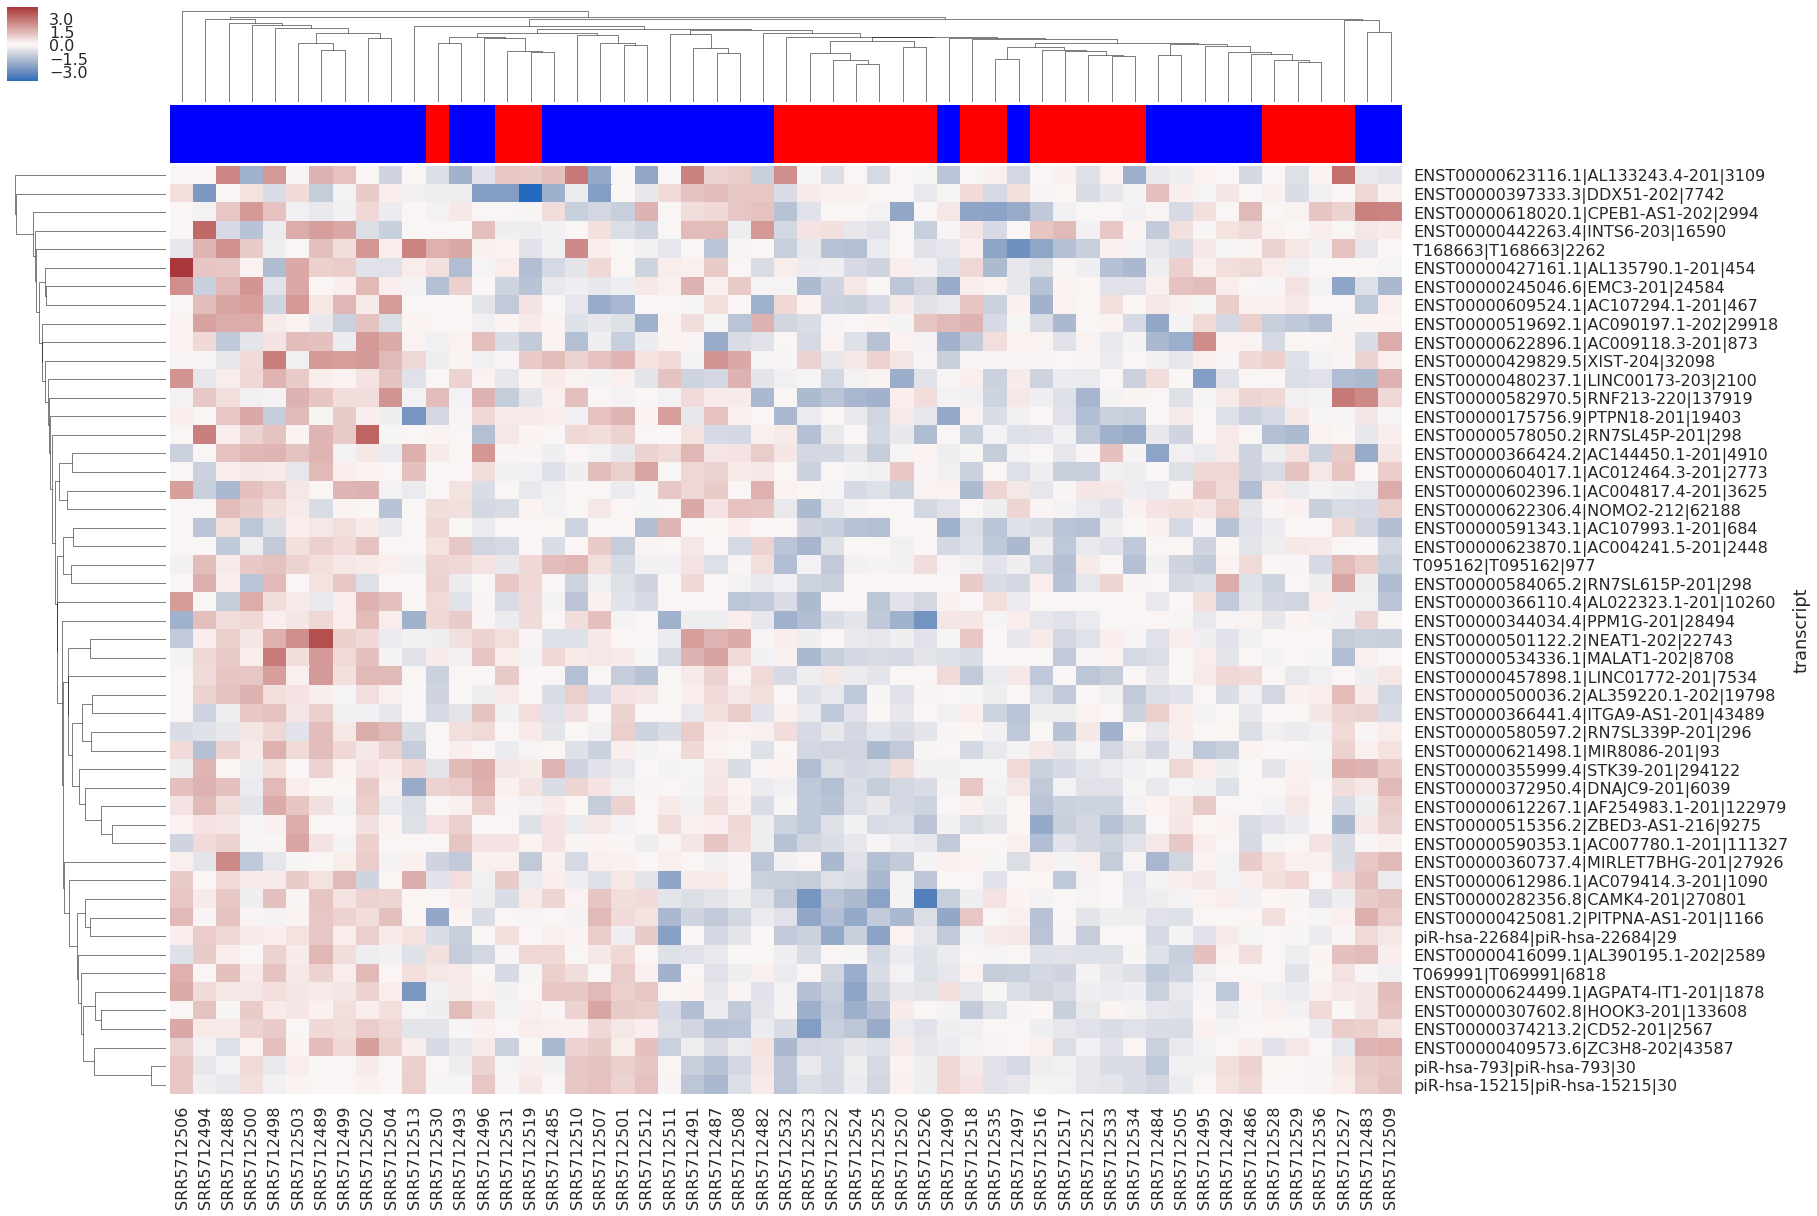

In [266]:
end = root_path_exoRBase.split('/')[-2]# transcripts_exrna'/'piranha_peaks'
m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/'+end+'.txt', index_col=0)
#print (features)
cpmtable= m.loc[features,sampless]
cpmmatrix=np.ma.log2(np.array(cpmtable))
cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
rgblabel = np.repeat('r',53)
rgblabel[21:] = 'b'
sns.clustermap(cpmtable,cmap='vlag',figsize=(25,20),col_colors=rgblabel)

In [96]:
features = pd.read_table(root_path[3]+'Normal-CRC/'+'logistic_regression.10.ranking.leave_one_out'+'/features.txt', header=None).iloc[:, 0]
m = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/GSE71008.txt', index_col=0)
sampless = np.concatenate((samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0],
                          samples_GSE[samples_GSE[1]=='Pancreatic Cancer'][0],samples_GSE[samples_GSE[1]=='Prostate Cancer'][0]))
cpmtable= m.loc[features,sampless]
cpmmatrix=np.ma.log2(np.array(cpmtable))
cpmtable.iloc[:,:] = RobustScaler().fit_transform(cpmmatrix.T).T
np.unique(samples_GSE[1],return_counts=True)

(array(['Colorectal Cancer', 'Healthy Control', 'Pancreatic Cancer',
        'Prostate Cancer'], dtype=object), array([100,  50,   6,  36]))

In [100]:
gsecount = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/count_matrix/GSE71008.txt')

In [101]:
gsecount.shape

(89619, 193)

In [103]:
gsecount.head()

,transcript,Sample_1S10,Sample_1S11,Sample_1S12,Sample_1S13,Sample_1S14,Sample_1S15,Sample_1S16,Sample_1S17,Sample_1S18,...,Sample_PC34,Sample_PC35,Sample_PC36,Sample_PC3,Sample_PC4,Sample_PC5,Sample_PC6,Sample_PC7,Sample_PC8,Sample_PC9
0,ENST00000473358.1|MIR1302-2HG-202|1544,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENST00000469289.1|MIR1302-2HG-201|843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENST00000466430.5|AL627309.1-201|31638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,ENST00000471248.1|AL627309.1-203|18221,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENST00000610542.1|AL627309.1-205|12999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
samples_GSE = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.GSE71008.txt', header=None)
sampless = np.concatenate((samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0]))

In [198]:
sampless[1:].shape

(150,)

In [107]:
gsecount[sampless].shape

(89619, 150)

In [695]:
binlabel = np.repeat('stageA',29)
binlabel[16:] = 'Normal'
pd.DataFrame(np.concatenate((binlabel.reshape(-1,1),rgblabel.reshape(-1,1)),axis=1))

In [242]:
root_path

['/home/chenxupeng/projects/training/data/transcripts_exrna/',
 '/home/chenxupeng/projects/training/data/piranha_peaks/',
 '/home/chenxupeng/projects/training/data/piranha_peaks_iterative/',
 '/home/chenxupeng/projects/training/data/GSE71008/',
 '/home/chenxupeng/projects/training/data/exoRBase/']

In [261]:
def plot_cluster(root_path,sample_path):
    '''
    sample_path:hccpath,stagepath
    '''
    for i in os.listdir(root_path+sample_path):
        print (i)
        try:
            print (i, ' file found')
            print ('data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png')
            if sample_path == hccpath:
                print ('true')
                if root_path =='/home/chenxupeng/projects/training/data/exoRBase/':
                    clustermap_exo_hcc(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
                else:
                    clustermap_hcc(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
            elif sample_path ==stagepath:
                clustermap_stage_A(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
            elif sample_path ==crcpath:
                clustermap_crc(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
            elif sample_path == paadpath:
                clustermap_exo_paad(root_path,i,'data/clustermap/'+root_path.split('/')[-2]+'/'+sample_path+i+'.png',savefigure=True,title=None)
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))

In [ ]:
for i in root_path[:3]:
    for j in sample_path[:2]:
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]):
            os.mkdir('data/clustermap/'+i.split('/')[-2])
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/clustermap/'+i.split('/')[-2]+'/'+j)
        plot_cluster(i,j)

In [262]:
sample_path

['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/', 'Normal-PAAD/']

In [245]:
root_path[3:4],sample_path[2:3]

(['/home/chenxupeng/projects/training/data/GSE71008/'], ['Normal-CRC/'])

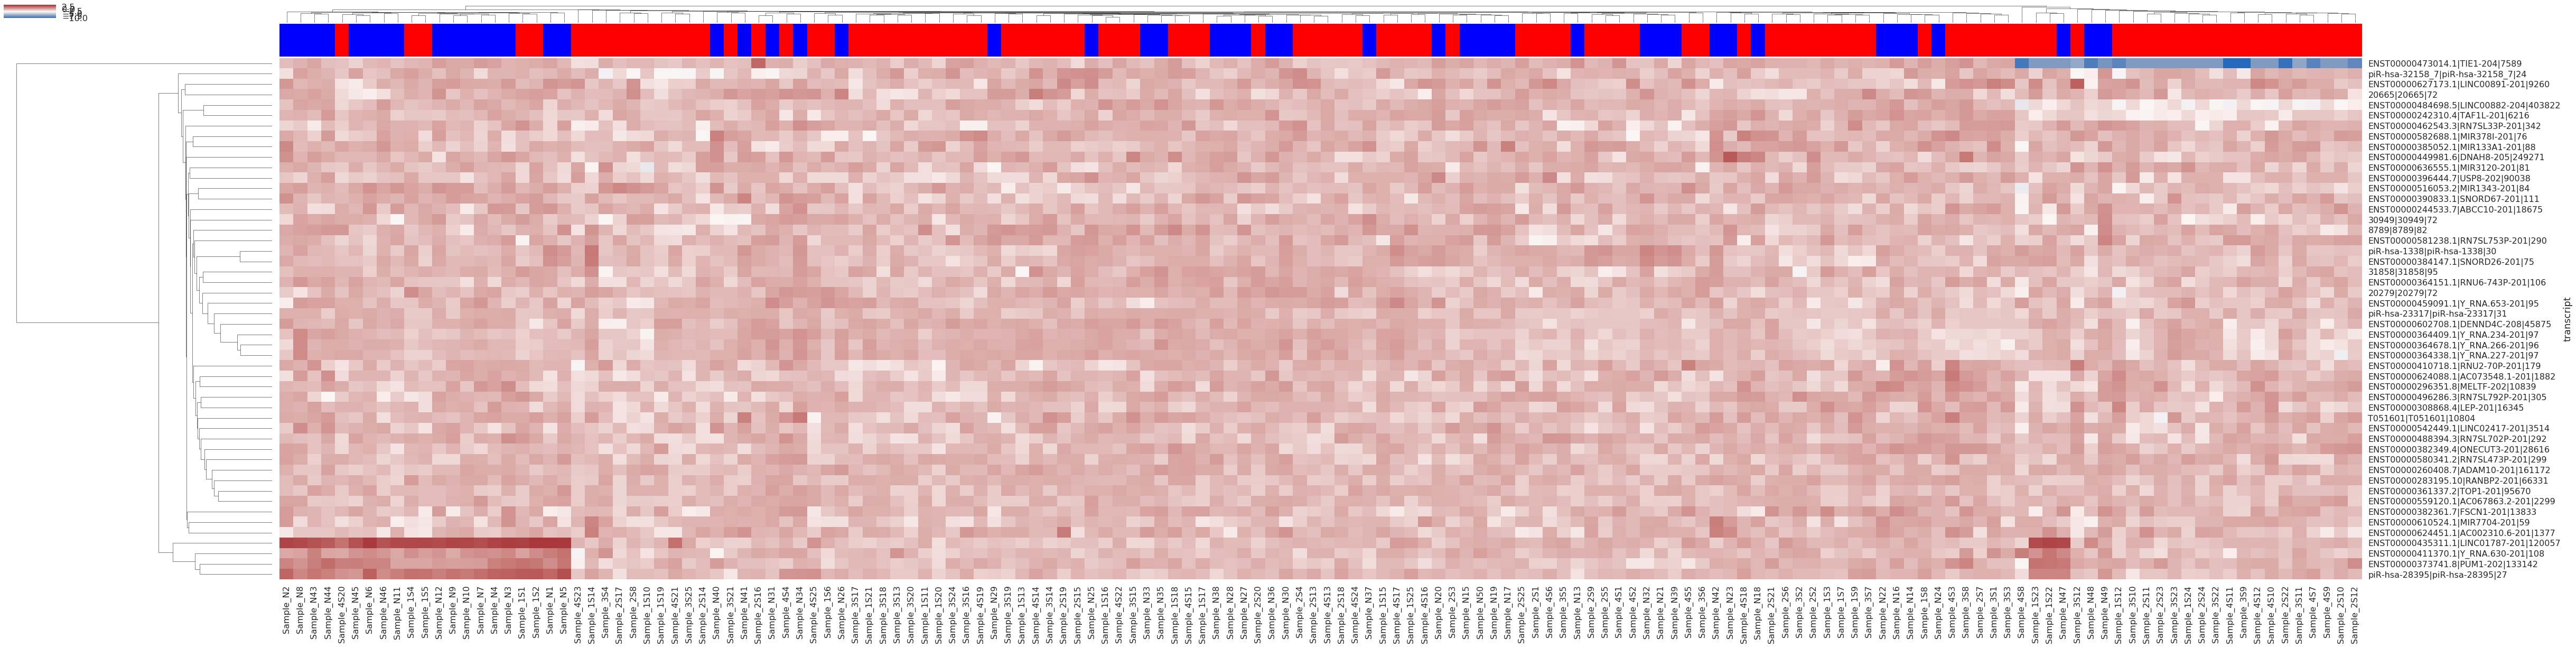

In [246]:
clustermap_crc('/home/chenxupeng/projects/training/data/GSE71008/','logistic_regression.50.ranking.stratified_shuffle_split','data/clustermap/'+
               '/home/chenxupeng/projects/training/data/GSE71008/'.split('/')[-2]+'/'+'Normal-CRC/'+'logistic_regression.50.ranking.stratified_shuffle_split'
               +'.png',savefigure=False,title=None)

In [269]:
root_path,sample_path

(['/home/chenxupeng/projects/training/data/transcripts_exrna/',
  '/home/chenxupeng/projects/training/data/piranha_peaks/',
  '/home/chenxupeng/projects/training/data/piranha_peaks_iterative/',
  '/home/chenxupeng/projects/training/data/GSE71008/',
  '/home/chenxupeng/projects/training/data/exoRBase/'],
 ['Normal-HCC/', 'Normal-stage_A/', 'Normal-CRC/', 'Normal-PAAD/'])

In [280]:
for i in tqdm(root_path[:3]):
    for j in tqdm(np.array(sample_path)[np.array([0,1])]):
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]):
            os.mkdir('data/clustermap/'+i.split('/')[-2])
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/clustermap/'+i.split('/')[-2]+'/'+j)
        plot_cluster(i,j)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.50.ranking.stratified_shuffle_split
logistic_regression.50.ranking.stratified_shuffle_split  file found
data/clustermap/transcripts_exrna/Normal-HCC/logistic_regression.50.ranking.stratified_shuffle_split.png
true
logistic_regression.30.rfe.leave_one_out
logistic_regression.30.rfe.leave_one_out  file found
data/clustermap/transcripts_exrna/Normal-HCC/logistic_regression.30.rfe.leave_one_out.png
true
logistic_regression.30.rfe.stratified_shuffle_split
logistic_regression.30.rfe.stratified_shuffle_split  file found
data/clustermap/transcripts_exrna/Normal-HCC/logistic_regression.30.rfe.stratified_shuffle_split.png
true
logistic_regression.50.rfe.leave_one_out
logistic_regression.50.rfe.leave_one_out  file found
data/clustermap/transcripts_exrna/Normal-HCC/logistic_regression.50.rfe.leave_one_out.png
true
logistic_regression.100.ranking.stratified_shuffle_split
logistic_regression.100.ranking.stratified_shuffle_split  file found
data/clustermap/transcripts_exrna/Normal

logistic_regression.50.ranking.leave_one_out
logistic_regression.50.ranking.leave_one_out  file found
data/clustermap/transcripts_exrna/Normal-stage_A/logistic_regression.50.ranking.leave_one_out.png
logistic_regression.100.robust.stratified_shuffle_split
logistic_regression.100.robust.stratified_shuffle_split  file found
data/clustermap/transcripts_exrna/Normal-stage_A/logistic_regression.100.robust.stratified_shuffle_split.png
random_forest.30.rfe.leave_one_out
random_forest.30.rfe.leave_one_out  file found
data/clustermap/transcripts_exrna/Normal-stage_A/random_forest.30.rfe.leave_one_out.png
random_forest.50.ranking.stratified_shuffle_split
random_forest.50.ranking.stratified_shuffle_split  file found
data/clustermap/transcripts_exrna/Normal-stage_A/random_forest.50.ranking.stratified_shuffle_split.png
random_forest.50.rfe.stratified_shuffle_split
random_forest.50.rfe.stratified_shuffle_split  file found
data/clustermap/transcripts_exrna/Normal-stage_A/random_forest.50.rfe.stratifi

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.50.ranking.stratified_shuffle_split
logistic_regression.50.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-HCC/logistic_regression.50.ranking.stratified_shuffle_split.png
true
logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-HCC/logistic_regression.40.robust.stratified_shuffle_split.png
true
random_forest.40.robust.stratified_shuffle_split
random_forest.40.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-HCC/random_forest.40.robust.stratified_shuffle_split.png
true
logistic_regression.30.rfe.leave_one_out
logistic_regression.30.rfe.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-HCC/logistic_regression.30.rfe.leave_one_out.png
true
logistic_regression.30.rfe.stratified_shuffle_split
logistic_regression.30.rfe.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Nor

random_forest.100.rfe.stratified_shuffle_split
random_forest.100.rfe.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-HCC/random_forest.100.rfe.stratified_shuffle_split.png
true
random_forest.50.robust.leave_one_out
random_forest.50.robust.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-HCC/random_forest.50.robust.leave_one_out.png
true
random_forest.30.robust.leave_one_out
random_forest.30.robust.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-HCC/random_forest.30.robust.leave_one_out.png
true
logistic_regression.50.ranking.stratified_shuffle_split
logistic_regression.50.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-stage_A/logistic_regression.50.ranking.stratified_shuffle_split.png
logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-stage_A/logistic_regression.40.robust.stratified_shuffle_

logistic_regression.10.robust.leave_one_out
logistic_regression.10.robust.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-stage_A/logistic_regression.10.robust.leave_one_out.png
random_forest.20.robust.leave_one_out
random_forest.20.robust.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-stage_A/random_forest.20.robust.leave_one_out.png
logistic_regression.40.robust.leave_one_out
logistic_regression.40.robust.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-stage_A/logistic_regression.40.robust.leave_one_out.png
logistic_regression.30.robust.stratified_shuffle_split
logistic_regression.30.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks/Normal-stage_A/logistic_regression.30.robust.stratified_shuffle_split.png
logistic_regression.50.robust.leave_one_out
logistic_regression.50.robust.leave_one_out  file found
data/clustermap/piranha_peaks/Normal-stage_A/logistic_regression.50.robust.leave_one_out.png
random_forest.100.rf

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

logistic_regression.50.ranking.stratified_shuffle_split
logistic_regression.50.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/logistic_regression.50.ranking.stratified_shuffle_split.png
true
logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/logistic_regression.40.robust.stratified_shuffle_split.png
true
random_forest.40.robust.stratified_shuffle_split
random_forest.40.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/random_forest.40.robust.stratified_shuffle_split.png
true
logistic_regression.10.rfe.stratified_shuffle_split
logistic_regression.10.rfe.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/logistic_regression.10.rfe.stratified_shuffle_split.png
true
logistic_regression.30.rfe.leave_one_out
logistic_regression.30.rfe.leave_on

logistic_regression.100.rfe.stratified_shuffle_split
logistic_regression.100.rfe.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/logistic_regression.100.rfe.stratified_shuffle_split.png
true
logistic_regression.20.robust.stratified_shuffle_split
logistic_regression.20.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/logistic_regression.20.robust.stratified_shuffle_split.png
true
random_forest.10.ranking.stratified_shuffle_split
random_forest.10.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/random_forest.10.ranking.stratified_shuffle_split.png
true
random_forest.100.ranking.stratified_shuffle_split
random_forest.100.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-HCC/random_forest.100.ranking.stratified_shuffle_split.png
true
random_forest.100.rfe.leave_one_out
random_forest.100.rfe.leave_one_out  file found
d

logistic_regression.50.rfe.leave_one_out
logistic_regression.50.rfe.leave_one_out  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/logistic_regression.50.rfe.leave_one_out.png
logistic_regression.20.ranking.stratified_shuffle_split
logistic_regression.20.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/logistic_regression.20.ranking.stratified_shuffle_split.png
random_forest.40.rfe.stratified_shuffle_split
random_forest.40.rfe.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/random_forest.40.rfe.stratified_shuffle_split.png
logistic_regression.100.ranking.stratified_shuffle_split
logistic_regression.100.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/logistic_regression.100.ranking.stratified_shuffle_split.png
logistic_regression.50.ranking.leave_one_out
logistic_regression.50.ranking.leave_one_out  file found
data/clusterma

random_forest.100.robust.leave_one_out
random_forest.100.robust.leave_one_out  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/random_forest.100.robust.leave_one_out.png
logistic_regression.10.ranking.stratified_shuffle_split
logistic_regression.10.ranking.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/logistic_regression.10.ranking.stratified_shuffle_split.png
random_forest.10.rfe.stratified_shuffle_split
random_forest.10.rfe.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/random_forest.10.rfe.stratified_shuffle_split.png
random_forest.50.robust.stratified_shuffle_split
random_forest.50.robust.stratified_shuffle_split  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/random_forest.50.robust.stratified_shuffle_split.png
random_forest.50.rfe.leave_one_out
random_forest.50.rfe.leave_one_out  file found
data/clustermap/piranha_peaks_iterative/Normal-stage_A/random_fo

In [281]:
for i in tqdm(root_path[4:5]):
    for j in tqdm(np.array(sample_path)[np.array([0,3])]):
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]):
            os.mkdir('data/clustermap/'+i.split('/')[-2])
        if not os.path.exists('data/clustermap/'+i.split('/')[-2]+'/'+j):
            os.mkdir('data/clustermap/'+i.split('/')[-2]+'/'+j)
        plot_cluster(i,j)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

logistic_regression.50.ranking.stratified_shuffle_split
logistic_regression.50.ranking.stratified_shuffle_split  file found
data/clustermap/exoRBase/Normal-PAAD/logistic_regression.50.ranking.stratified_shuffle_split.png
logistic_regression.40.robust.stratified_shuffle_split
logistic_regression.40.robust.stratified_shuffle_split  file found
data/clustermap/exoRBase/Normal-PAAD/logistic_regression.40.robust.stratified_shuffle_split.png
random_forest.40.robust.stratified_shuffle_split
random_forest.40.robust.stratified_shuffle_split  file found
data/clustermap/exoRBase/Normal-PAAD/random_forest.40.robust.stratified_shuffle_split.png
logistic_regression.10.rfe.stratified_shuffle_split
logistic_regression.10.rfe.stratified_shuffle_split  file found
data/clustermap/exoRBase/Normal-PAAD/logistic_regression.10.rfe.stratified_shuffle_split.png
logistic_regression.30.rfe.leave_one_out
logistic_regression.30.rfe.leave_one_out  file found
data/clustermap/exoRBase/Normal-PAAD/logistic_regression.3

random_forest.10.robust.stratified_shuffle_split
random_forest.10.robust.stratified_shuffle_split  file found
data/clustermap/exoRBase/Normal-PAAD/random_forest.10.robust.stratified_shuffle_split.png
logistic_regression.20.robust.leave_one_out
logistic_regression.20.robust.leave_one_out  file found
data/clustermap/exoRBase/Normal-PAAD/logistic_regression.20.robust.leave_one_out.png
random_forest.30.ranking.leave_one_out
random_forest.30.ranking.leave_one_out  file found
data/clustermap/exoRBase/Normal-PAAD/random_forest.30.ranking.leave_one_out.png
logistic_regression.10.robust.leave_one_out
logistic_regression.10.robust.leave_one_out  file found
data/clustermap/exoRBase/Normal-PAAD/logistic_regression.10.robust.leave_one_out.png
random_forest.20.robust.leave_one_out
random_forest.20.robust.leave_one_out  file found
data/clustermap/exoRBase/Normal-PAAD/random_forest.20.robust.leave_one_out.png
logistic_regression.40.robust.leave_one_out
logistic_regression.40.robust.leave_one_out  file

## statistics about LncRNA

In [501]:
rootpath_publish = '/BioII/lulab_b/wangsiqi/exRNA/published/exosome_SR2017_GSE71008/stat/'

In [522]:
lnccounts = {}
wholecounts = {}
for i in os.listdir(rootpath_publish):
    print (i)
    if i.split('.')[1] =='readsN':
        table = pd.read_table(rootpath_publish+i,names=['sample','process','name','counts'])
        lnccounts[i] =int(table[table['name'] =='lncRNA']['counts'])
        wholecounts[i] =int(table[table['name'] =='cleanN']['counts'])

Sample_1S10.readsN.stat.tsv
Sample_1S11.readsN.stat.tsv
Sample_1S12.readsN.stat.tsv
Sample_1S13.readsN.stat.tsv
Sample_1S14.readsN.stat.tsv
Sample_1S15.readsN.stat.tsv
Sample_1S16.readsN.stat.tsv
Sample_1S17.readsN.stat.tsv
Sample_1S18.readsN.stat.tsv
Sample_1S19.readsN.stat.tsv
Sample_1S1.readsN.stat.tsv
Sample_1S20.readsN.stat.tsv
Sample_1S21.readsN.stat.tsv
Sample_1S22.readsN.stat.tsv
Sample_1S23.readsN.stat.tsv
Sample_1S24.readsN.stat.tsv
Sample_1S25.readsN.stat.tsv
Sample_1S2.readsN.stat.tsv
Sample_1S3.readsN.stat.tsv
Sample_1S4.readsN.stat.tsv
Sample_1S5.readsN.stat.tsv
Sample_1S6.readsN.stat.tsv
Sample_1S7.readsN.stat.tsv
Sample_1S8.readsN.stat.tsv
Sample_1S9.readsN.stat.tsv
Sample_2S10.readsN.stat.tsv
Sample_2S11.readsN.stat.tsv
Sample_2S12.readsN.stat.tsv
Sample_2S13.readsN.stat.tsv
Sample_2S14.readsN.stat.tsv
Sample_2S15.readsN.stat.tsv
Sample_2S16.readsN.stat.tsv
Sample_2S17.readsN.stat.tsv
Sample_2S18.readsN.stat.tsv
Sample_2S19.readsN.stat.tsv
Sample_2S1.readsN.stat.tsv
Sa

In [512]:
table = pd.read_table(rootpath_publish+'Sample_N18.readsN.stat.tsv',names=['sample','process','name','counts'])
table[table['name'] =='lncRNA']['counts']

11    32972
Name: counts, dtype: int64

In [528]:
lnccount = np.array([lnccounts[i] for i in lnccounts.keys()])
wholecount = np.array([wholecounts[i] for i in wholecounts.keys()])

(array([ 1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
        10., 10., 14., 12., 14., 15.,  3., 12., 14.,  9.,  9.,  5.,  8.,
        11.,  3.,  6.,  6.,  5.,  4.,  2.,  3.,  1.,  4.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 8885.,  9971., 11057., 12143., 13229., 14315., 15401., 16487.,
        17573., 18659., 19745., 20831., 21917., 23003., 24089., 25175.,
        26261., 27347., 28433., 29519., 30605., 31691., 32777., 33863.,
        34949., 36035., 37121., 38207., 39293., 40379., 41465., 42551.,
        43637., 44723., 45809., 46895., 47981., 49067., 50153., 51239.,
        52325., 53411., 54497., 55583., 56669., 57755., 58841., 59927.,
        61013., 62099., 63185.]),
 <a list of 50 Patch objects>)

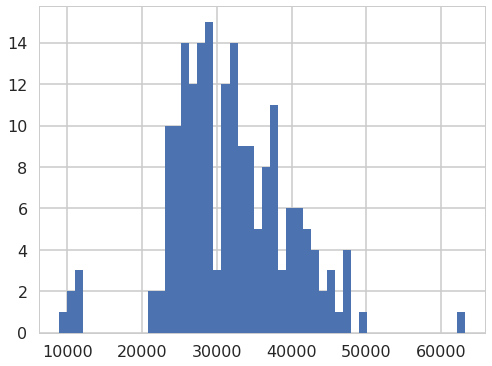

In [532]:
fig,ax=plt.subplots(1,figsize=(8,6))
ax.hist(lnccount,bins=50)

Text(0.5,1,'Counts of lncRNA')

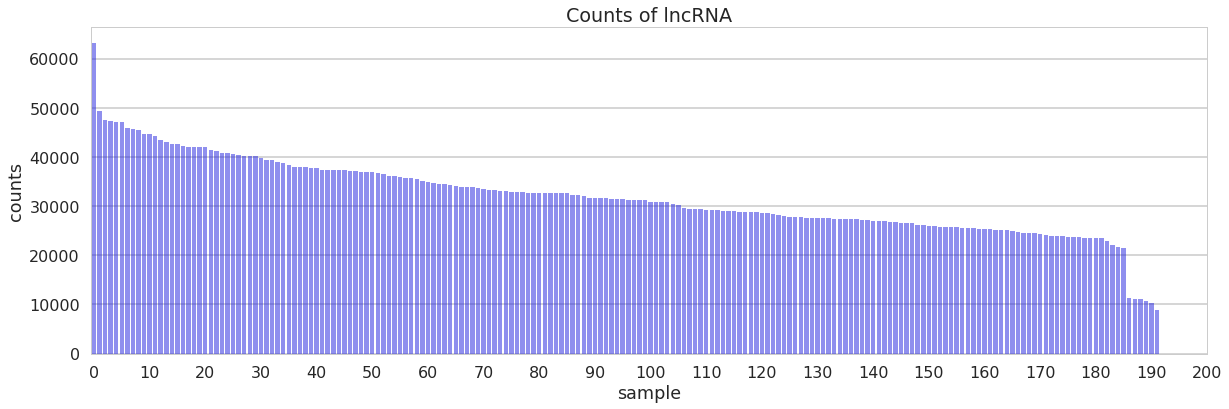

In [576]:
fig,ax=plt.subplots(1,figsize=(20,6))
counttable =  pd.DataFrame(np.concatenate((np.arange(1,193).reshape(-1,1),~np.sort(~lnccount).reshape(-1,1)),axis=1),columns=['sample','counts'])
sns.barplot(x='sample',y='counts',data = counttable,color='b',alpha=0.5)
ax.set_xticks(np.arange(0,210,10))
ax.set_xticklabels(np.arange(0,210,10))
ax.set_title('Counts of lncRNA')

Text(0.5,1,'Counts of cleanreads')

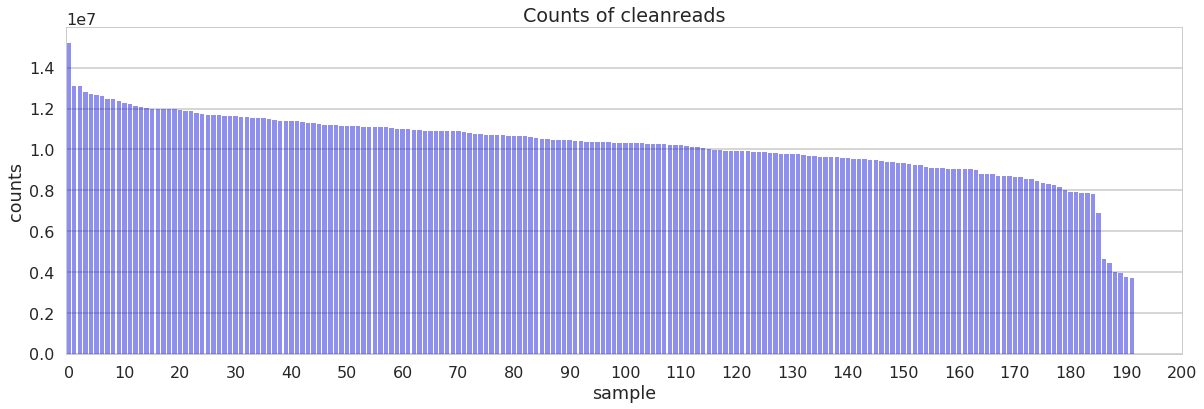

In [577]:
fig,ax=plt.subplots(1,figsize=(20,6))
counttable =  pd.DataFrame(np.concatenate((np.arange(1,193).reshape(-1,1),~np.sort(~wholecount).reshape(-1,1)),axis=1),columns=['sample','counts'])
sns.barplot(x='sample',y='counts',data = counttable,color='b',alpha=0.5)
ax.set_xticks(np.arange(0,210,10))
ax.set_xticklabels(np.arange(0,210,10))
ax.set_title('Counts of cleanreads')

Text(0.5,1,'Ratio of lncrna and cleanreads')

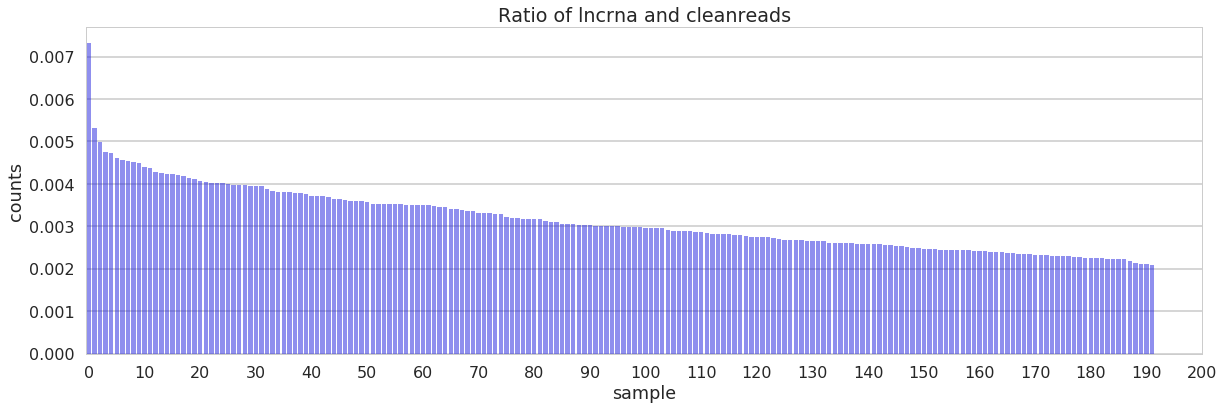

In [578]:
fig,ax=plt.subplots(1,figsize=(20,6))
ratio = lnccount/wholecount
counttable =  pd.DataFrame(np.concatenate((np.arange(1,193).reshape(-1,1),np.flip(np.sort(ratio),axis=0).reshape(-1,1)),axis=1),columns=['sample','counts'])
sns.barplot(x='sample',y='counts',data = counttable,color='b',alpha=0.5)
ax.set_xticks(np.arange(0,210,10))
ax.set_xticklabels(np.arange(0,210,10))
ax.set_title('Ratio of lncrna and cleanreads')

###  process CRC data

In [122]:
gsecount = pd.read_table('/Share/home/shibinbin/projects/exRNA/output/count_matrix/GSE71008.txt')
samples_GSE = pd.read_table('/Share/home/shibinbin/projects/exRNA/metadata/sample_classes.GSE71008.txt', header=None)
sampless = np.concatenate((np.array(['transcript']),samples_GSE[samples_GSE[1]=='Colorectal Cancer'][0],samples_GSE[samples_GSE[1]=='Healthy Control'][0]))
matrix = gsecount[sampless]

In [170]:
samples_GSE

,0,1
0,Sample_1S3,Colorectal Cancer
1,Sample_1S6,Colorectal Cancer
2,Sample_1S9,Colorectal Cancer
3,Sample_1S12,Colorectal Cancer
4,Sample_1S15,Colorectal Cancer
5,Sample_1S18,Colorectal Cancer
6,Sample_1S21,Colorectal Cancer
7,Sample_1S24,Colorectal Cancer
8,Sample_4S2,Colorectal Cancer
9,Sample_4S5,Colorectal Cancer


In [115]:
matrix.shape

(89619, 151)

In [162]:
matrix.index = matrix['transcript']

In [165]:
matrix.iloc[:,1:].to_csv('data/GSE_expreesionmx_binary.txt')

In [167]:
matrix.iloc[:,1:]

,Sample_1S3,Sample_1S6,Sample_1S9,Sample_1S12,Sample_1S15,Sample_1S18,Sample_1S21,Sample_1S24,Sample_4S2,Sample_4S5,...,Sample_N6,Sample_N12,Sample_N18,Sample_N24,Sample_N30,Sample_N36,Sample_N42,Sample_N48,Sample_N50,Sample_N49
transcript,,,,,,,,,,,,,,,,,,,,,
ENST00000473358.1|MIR1302-2HG-202|1544,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENST00000469289.1|MIR1302-2HG-201|843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENST00000466430.5|AL627309.1-201|31638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ENST00000471248.1|AL627309.1-203|18221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENST00000610542.1|AL627309.1-205|12999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENST00000493797.1|AL627309.2-201|550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENST00000484859.1|AL627309.5-201|8234,0,0,0,0,0,0,0,0,3,1,...,0,0,1,1,0,0,0,0,0,0
ENST00000466557.6|AL627309.5-203|27477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENST00000491962.1|AL627309.5-204|2879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
anno = samples_GSE[np.isin(samples_GSE[0],sampless[1:])]

In [139]:
anno.columns = ['Sample_ID','class']

In [140]:
anno.to_csv('data/GSE_expreesionmx_binary_annotation.txt')

In [169]:
pd.DataFrame(sampless[1:]).to_csv('data/GSE_expreesionmx_binary_header.txt')

In [151]:
ttt =np.sum(matrix,axis=1)

In [157]:
tttsort = ~np.sort(~ttt)

In [160]:
tttsort[:20].sum()/ttt.sum()

0.49556323457195234

In [156]:
np.unique(~np.sort(~ttt),return_counts=True)

(array([       0,        1,        2, ..., 17027999, 20062304, 49212324]),
 array([ 4209, 21530, 10129, ...,     1,     1,     1]))

In [ ]:
fig,ax=plt.subplots(1,figsize=(20,6))
counttable =  pd.DataFrame(np.concatenate((np.arange(1,193).reshape(-1,1),~np.sort(~wholecount).reshape(-1,1)),axis=1),columns=['sample','counts'])
sns.barplot(x='sample',y='counts',data = counttable,color='b',alpha=0.5)
ax.set_xticks(np.arange(0,210,10))
ax.set_xticklabels(np.arange(0,210,10))
ax.set_title('Counts of cleanreads')

In [171]:
pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/piranha_peaks_iterative.txt', index_col=0).shape

(3061, 81)

In [172]:
pd.read_table('/Share/home/shibinbin/projects/exRNA/output/cpm_matrix/transcripts_exrna.txt', index_col=0).shape

(143666, 61)

In [183]:
samples = np.array(pd.read_excel('data/GSE_sample_batch.xlsx').iloc[:,0])

In [188]:
samples_ = np.array(['Sample_'+samples[i] for i in range(samples.shape[0])])

In [184]:
batchs = np.array(pd.read_excel('data/GSE_sample_batch.xlsx').iloc[:,1])

In [200]:
table = pd.DataFrame(np.concatenate((samples_.reshape(-1,1),batchs.reshape(-1,1)),axis=1),
             columns=['sample','batch'])

In [206]:
table.iloc[np.isin(table['sample'],sampless)].to_csv('data/GSE_sample_batch.csv',sep=',')

In [ ]:
.to_excel('data/GSE_sample_batch.xlsx')